# Module import

In [1]:
from netCDF4 import Dataset                             
import numpy as np                                      
from scipy import ndimage                               
import matplotlib.pyplot as plt           
import matplotlib.colors as mcolors              
from matplotlib.patches import Rectangle                
from scipy.ndimage import zoom
from skimage.transform import resize
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature     
import cartopy.io.shapereader as shpreader
import sys
sys.path.append("/home/users/mendrika/SSA/SA/module")
import snflics # type: ignore
import torch  
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

# Choose nowcast origin and lead time (in hour)

In [2]:
year = "2022"
month = "02"
day = "10"
hour = "12"
minute = "00"

In [3]:
lead_time = 1

# Configurations

## Zambia extent

In [4]:
DISPLAY_LON_MIN = 21.167515
DISPLAY_LON_MAX = 35.316326
DISPLAY_LAT_MIN = -18.414806
DISPLAY_LAT_MAX = -7.9918404

In [ ]:
nflics_bounds = {
    "x_min_nflics": 365,
    "x_max_nflics": 758,
    "y_min_nflics": 256,
    "y_max_nflics": 590
}


# NFLICS

In [32]:
# Load metadata
geodata_flics = np.load("/gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/metadata/nflics_latlon_meshgrid.npz")
NFLICS_lats = geodata_flics["lats"]
NFLICS_lons = geodata_flics["lons"]

# Domain boundaries
DISPLAY_LON_MIN = 21.167515
DISPLAY_LON_MAX = 35.316326
DISPLAY_LAT_MIN = -18.414806
DISPLAY_LAT_MAX = -7.9918404

y_max_nflics, x_min_nflics = snflics.to_yx(DISPLAY_LAT_MIN, DISPLAY_LON_MIN, NFLICS_lats, NFLICS_lons)
y_min_nflics, x_max_nflics = snflics.to_yx(DISPLAY_LAT_MAX, DISPLAY_LON_MAX, NFLICS_lats, NFLICS_lons)

print(f"x_min_nflics = {x_min_nflics}, x_max_nflics = {x_max_nflics}")
print(f"y_min_nflics = {y_min_nflics}, y_max_nflics = {y_max_nflics}")

x_min_nflics = 365, x_max_nflics = 758
y_min_nflics = 256, y_max_nflics = 590


In [6]:
def load_NFLICS_nowcast(year, month, day, hour, minute, lead_time):
    NFLICS_BaseDir = f"/gws/ssde/j25b/swift/nflics_nowcasts/{year}/{month}/{day}/{hour}{minute}"
    file = f"{NFLICS_BaseDir}/Nowcast_{year}{month}{day}{hour}{minute}_000_sadc.nc"
    data = Dataset(file, mode='r')["Probability"][lead_time, :, :]
    return data

# Ground truth 

In [7]:
def update_hour(date_dict, hours_to_add, minutes_to_add):
    """
    Add hours and minutes to a datetime dictionary and return the updated dict and a generated file path.

    Args:
        date_dict     (dict): Keys: 'year', 'month', 'day', 'hour', 'minute' as strings, e.g. "01", "23"
        hours_to_add   (int): Number of hours to add.
        minutes_to_add (int): Number of minutes to add.

    Returns:
        tuple:
            - dict: Updated datetime dictionary with all fields as zero-padded strings.
            - str: File path in the format YYYY/MM/YYYYMMDDHHMM.nc
    """
    # Parse the original time
    time_obj = datetime(
        int(date_dict["year"]),
        int(date_dict["month"]),
        int(date_dict["day"]),
        int(date_dict["hour"]),
        int(date_dict["minute"])
    )

    # Add hours
    updated = time_obj + timedelta(hours=hours_to_add, minutes=minutes_to_add)

    # Format updated dictionary
    new_date_dict = {
        "year":   f"{updated.year:04d}",
        "month":  f"{updated.month:02d}",
        "day":    f"{updated.day:02d}",
        "hour":   f"{updated.hour:02d}",
        "minute": f"{updated.minute:02d}"
    }

    # Generate file path
    file_path = f"{new_date_dict['year']}/{new_date_dict['month']}/{new_date_dict['year']}{new_date_dict['month']}{new_date_dict['day']}{new_date_dict['hour']}{new_date_dict['minute']}.nc"

    return {'time': new_date_dict, 'path': file_path}

In [8]:
def load_wavelet_dataset(year, month, day, hour, minute, lead_time):
    
    nowcast_origin = {
        "year":   year,
        "month":  month,
        "day":    day,
        "hour":   hour,
        "minute": minute,
    }

    nowcast_lt = update_hour(nowcast_origin, hours_to_add=lead_time, minutes_to_add=0)["time"]

    path_core = f"/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{nowcast_lt['year']}/{nowcast_lt['month']}"
    file = f"{path_core}/{nowcast_lt['year']}{nowcast_lt['month']}{nowcast_lt['day']}{nowcast_lt['hour']}{nowcast_lt['minute']}.nc"
    return Dataset(file, mode='r')["cores"]

In [9]:
y_min, y_max = 580, 930
x_min, x_max = 1480, 1850

In [10]:
geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
Zambia_lons = geodata["lon"][y_min:y_max, x_min:x_max]
Zambia_lats = geodata["lat"][y_min:y_max, x_min:x_max]

In [35]:
nflics = load_NFLICS_nowcast(year, month, day, hour, minute, lead_time)[y_min_nflics:y_max_nflics, x_min_nflics:x_max_nflics]

In [80]:
ground_truth = load_wavelet_dataset(year, month, day, hour, minute, lead_time)[0, y_min:y_max, x_min:x_max] != 0

In [81]:
CONTEXT_LAT_MIN = np.min(Zambia_lats)
CONTEXT_LAT_MAX = np.max(Zambia_lats)
CONTEXT_LON_MIN = np.min(Zambia_lons)
CONTEXT_LON_MAX = np.max(Zambia_lons)

In [82]:
locations = {
    "Lusaka": [-15.3875, 28.3228],
    "Ndola": [-12.9683, 28.6366],
    "Kasama": [-10.2129, 31.1808],
    "Chinsali": [-10.5500, 32.0667],
    "Kabwe": [-14.4469, 28.4464],
    "Livingstone": [-17.8419, 25.8542],
    "Mongu": [-15.2484, 23.1274],
    "Mansa": [-11.1996, 28.8943],
    "Solwezi": [-12.1722, 26.3981],
    "Chipata": [-13.6339, 32.6508]
}

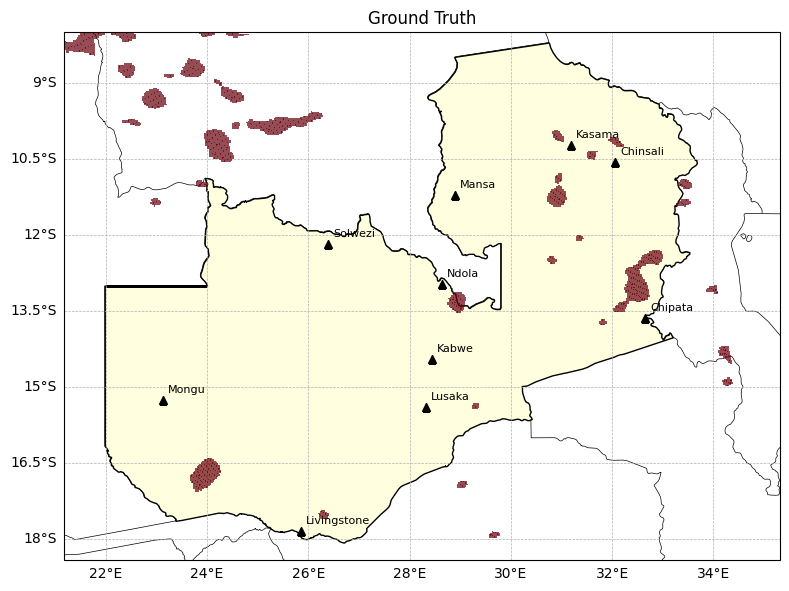

In [83]:
# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set tight extent around Zambia
ax.set_extent([CONTEXT_LON_MIN, CONTEXT_LON_MAX, CONTEXT_LAT_MIN, CONTEXT_LAT_MAX], crs=ccrs.PlateCarree())

# Base features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

# Load Natural Earth country boundaries and extract Zambia only
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='10m',
                                        category='cultural', name=shapename)

for country in shpreader.Reader(countries_shp).records():
    if country.attributes['NAME'] == 'Zambia':
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor='lightyellow', edgecolor='black', linewidth=1.0, zorder=2)

# Plot locations
for name, (lat, lon) in locations.items():
    ax.plot(lon, lat, marker="^", color="black", markersize=6, transform=ccrs.PlateCarree(), zorder=3)
    ax.text(lon + 0.1, lat + 0.1, name, fontsize=8, transform=ccrs.PlateCarree(), ha='left', va='bottom', color='black', zorder=4)

# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=1, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False

# --- Plot the binary storm core mask ---
# Ensure output_data is binary (0 or 1)
# e.g., output_data = (cores != 0).astype(int)

# Mask zeros to make them transparent
masked_output = np.ma.masked_where(ground_truth == 0, ground_truth)

# Plot only the "blobs" (value == 1)
contour_core = ax.pcolormesh(
    Zambia_lons, Zambia_lats, masked_output,
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.Reds,
    vmin=0, vmax=1,
    alpha=0.7,  # adjust opacity as you like
    zorder=2
)

plt.title("Ground Truth", fontsize=12)
plt.tight_layout()
plt.show()

# NFLICS

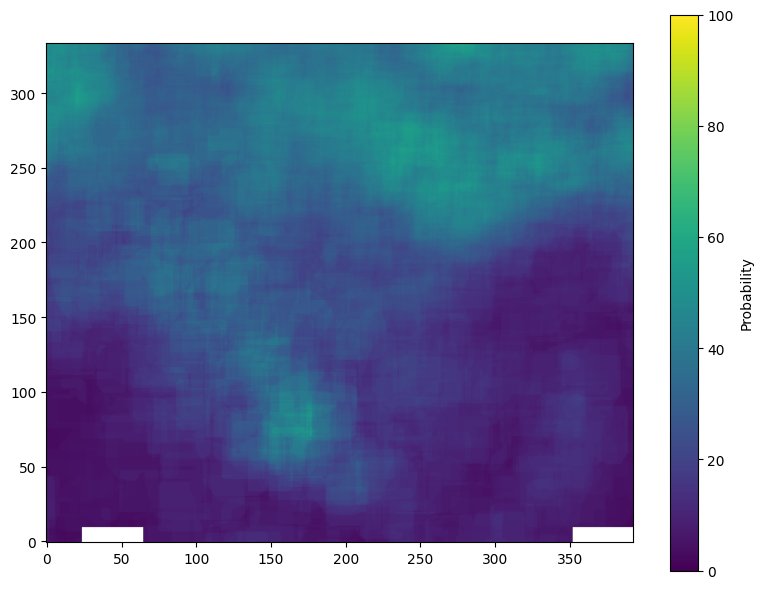

In [42]:
nflics_masked = np.ma.masked_where(nflics <= 0, nflics)

# Plot
plt.figure(figsize=(8, 6))
nflics_plot = plt.imshow(
    nflics_masked,
    origin="lower",
    cmap="viridis",
    vmin=0, vmax=100  # if it’s a probability field
)
plt.colorbar(nflics_plot, label="Probability")
plt.tight_layout()
plt.show()

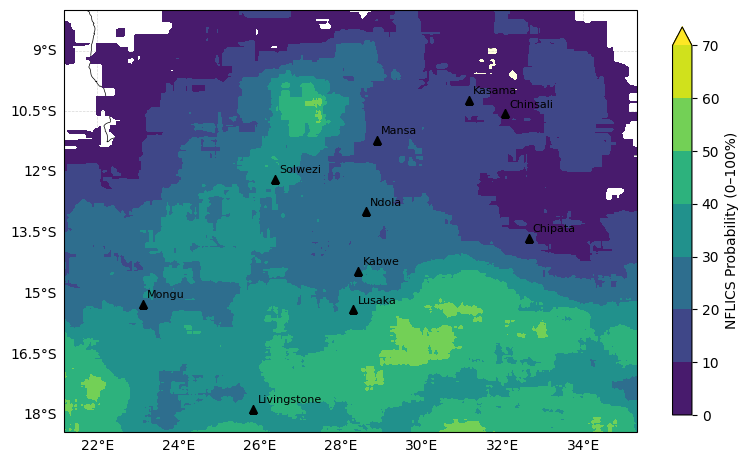

In [85]:
# --- Plot NFLICS nowcast probability field (same style as NetCC) ---

# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set tight extent around Zambia
ax.set_extent(
    [DISPLAY_LON_MIN, DISPLAY_LON_MAX,
     DISPLAY_LAT_MIN, DISPLAY_LAT_MAX],
    crs=ccrs.PlateCarree()
)

# Base features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

# Load Natural Earth country boundaries and extract Zambia only
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(
    resolution='10m',
    category='cultural',
    name=shapename
)

for country in shpreader.Reader(countries_shp).records():
    if country.attributes['NAME'] == 'Zambia':
        ax.add_geometries(
            [country.geometry],
            crs=ccrs.PlateCarree(),
            facecolor='lightyellow',
            edgecolor='black',
            linewidth=1.0,
            zorder=2
        )

# Plot locations
for name, (lat, lon) in locations.items():
    ax.plot(lon, lat, marker="^", color="black", markersize=6,
            transform=ccrs.PlateCarree(), zorder=3)
    ax.text(lon + 0.1, lat + 0.1, name, fontsize=8,
            transform=ccrs.PlateCarree(), ha='left', va='bottom',
            color='black', zorder=4)

# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False

# Mask zero/low values (so they become transparent)
NFLICS_masked = np.ma.masked_where(nflics <= 5, nflics)

# Plot NFLICS nowcast field only where > 10
contour_core = ax.contourf(
    NFLICS_lons,
    NFLICS_lats,
    NFLICS_masked,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    extend="max",
    zorder=2
)

# --- Add colourbar ---
cbar = plt.colorbar(contour_core, ax=ax, orientation="vertical", shrink=0.4, pad=0.05)
cbar.set_label("NFLICS Probability (0–100%)", fontsize=10)

plt.tight_layout()
plt.show()


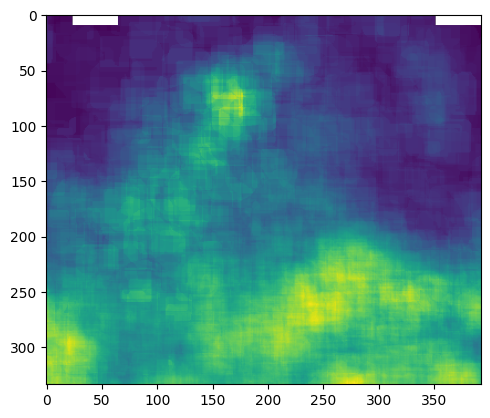

In [43]:
nflics_masked = np.ma.masked_where(nflics <= 0, nflics)

plt.imshow(nflics_masked)

In [97]:
def extract_box(matrix, y, x, box_size=3):
    half = box_size // 2
    y_min = max(y - half, 0)
    y_max = min(y + half + 1, matrix.shape[0])
    x_min = max(x - half, 0)
    x_max = min(x + half + 1, matrix.shape[1])
    return matrix[y_min:y_max, x_min:x_max]

yx_locations = {}

for name, (lat, lon) in locations.items():
    # Get indices on both grids
    y_nflics, x_nflics = snflics.to_yx(lat, lon, NFLICS_lats, NFLICS_lons)
    y_gt, x_gt = snflics.to_yx(lat, lon, Zambia_lats, Zambia_lons)

    print(y_gt, x_gt)

    # Extract values
    nflics_val = float(np.mean(extract_box(nflics, y_nflics, x_nflics)))
    gt_val     = int(np.max(extract_box(ground_truth, y_gt, x_gt)))

    # Store all in dictionary
    yx_locations[name] = (
        int(y_nflics), 
        int(x_nflics), 
        int(y_gt),
        int(x_gt),
        round(nflics_val, 4), 
        gt_val
    )

# Neat printout
for city, (y, x, ygt, xgt, nflics_val, gt_val) in yx_locations.items():
    print(f"{city:12s} | y={y:3d}, x={x:3d}   y_gt={ygt:3d}, x_gt={xgt:3d}  | NFLICS={nflics_val:.4f} | GT={gt_val}")


95 196
177 217
275 302
264 325
126 204
9 110
95 39
239 232
203 153
158 328
Lusaka       | y=493, x=564   y_gt= 95, x_gt=196  | NFLICS=31.8254 | GT=0
Ndola        | y=415, x=573   y_gt=177, x_gt=217  | NFLICS=23.3413 | GT=0
Kasama       | y=327, x=643   y_gt=275, x_gt=302  | NFLICS=11.5714 | GT=0
Chinsali     | y=338, x=668   y_gt=264, x_gt=325  | NFLICS=8.2738 | GT=0
Kabwe        | y=463, x=567   y_gt=126, x_gt=204  | NFLICS=27.4167 | GT=0
Livingstone  | y=571, x=495   y_gt=  9, x_gt=110  | NFLICS=34.8690 | GT=0
Mongu        | y=488, x=420   y_gt= 95, x_gt= 39  | NFLICS=25.4405 | GT=0
Mansa        | y=359, x=580   y_gt=239, x_gt=232  | NFLICS=14.5357 | GT=0
Solwezi      | y=390, x=511   y_gt=203, x_gt=153  | NFLICS=35.3095 | GT=0
Chipata      | y=437, x=684   y_gt=158, x_gt=328  | NFLICS=13.3452 | GT=0


In [88]:
import os
import pandas as pd

def save_city_nowcasts_by_lead(yx_locations, nowcast_origin, lead_time):
    """
    Saves one CSV per lead time.
    Each row = one nowcast_origin (t0)
    Columns = city_t{lead_time}, city_gt
    """
    # Directory by lead time
    base_save_dir = f"/gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/time_series/nflics/t{lead_time}"
    os.makedirs(base_save_dir, exist_ok=True)

    save_path = f"{base_save_dir}/city_nowcasts_t{lead_time}.csv"

    # Build a single row
    if isinstance(nowcast_origin, datetime):
        nowcast_origin_str = nowcast_origin.strftime("%Y-%m-%d %H:%M")
    else:
        nowcast_origin_str = str(nowcast_origin)

    row = {"t0": nowcast_origin_str}
    for city, (y, x, nflics_val, gt_val) in yx_locations.items():
        row[f"{city}_t{lead_time}"] = round(nflics_val, 4)
        row[f"{city}_gt_lt{lead_time}"] = int(gt_val)

    df = pd.DataFrame([row])

    # Append or create
    if os.path.exists(save_path):
        df.to_csv(save_path, mode="a", header=False, index=False)
    else:
        df.to_csv(save_path, mode="w", header=True, index=False)

    print(f"Appended results for {nowcast_origin_str} to {save_path}")


In [16]:
# nowcast_origin = datetime(int(year), int(month), int(day), int(hour), int(minute))
# save_city_nowcasts_by_lead(yx_locations, nowcast_origin, lead_time)